# Предсказание риска ДТП

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика:

Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)<br>
Для модели выбрать тип виновника — только машина (car).<br>
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).<br>
Для моделирования ограничиться данными за 2012 год — они самые свежие.<br>
Обязательное условие — учесть фактор возраста автомобиля.<br>
На основе модели исследовать основные факторы ДТП.<br>
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?<br>
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Подключение к базе. Загрузка таблицы данных

In [1]:
import pandas as pd
from sqlalchemy import create_engine 

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

#сторока подключения к базе данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

Настройки подключения готовы.

## Первичное исследование таблиц

- Все ли таблицы имеют набор данных;
- Соответствует ли количество таблиц условию задачи;
- Имеется ли общий ключ для связи таблиц.

In [3]:
sql_query = """
SELECT *
FROM parties
"""
parties = pd.read_sql_query(sql_query, con=engine)
print('Первые пять строк таблицы parties:')
display(parties.head(20))
print('Информация о таблице parties:')
print(parties.info())

Первые пять строк таблицы parties:


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


Информация о таблице parties:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB
None


| Описание                                                     | Обозначение в таблице | Подробнее                                                    |
|:------------------------------------------------------------ |:--------------------- |:------------------------------------------------------------ |
| Идентификационный номер                                      | ID                    | Уникальный идентификатор                                                                          |
| Идентификационный номер в базе данных                        | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Номер участника происшествия                                 | PARTY_NUMBER          | От 1 до N — по числу участников происшествия                 |
| Тип участника происшествия                                   | PARTY_TYPE            | 1 — Car (Авто)<br />2 — Road bumper (Дорожные знаки)<br />3 — Building (Строения)<br />4 — Road signs (Отбойник)<br />5 — Other (Другое)<br />6 — Operator (Оператор)<br />- — Not Stated (Не указано) |
| Виновность участника                                         | AT_FAULT              | 0/1                                                          |
| Сумма страховки (тыс. $)                                     | INSURANCE_PREMIUM     | число                                                        |
| Состояние участника: физическое или с учётом принятых лекарств | PARTY_DRUG_PHYSICAL   | E — Under Drug Influence (Под воздействием лекарств)<br />F — Impairment — Physical (Ухудшение состояния)<br />G — Impairment Unknown (Не известно)<br />H — Not Applicable (Не оценивался)<br />I — Sleepy/Fatigued (Сонный/Усталый)- — Not Stated (Не указано) |
| Трезвость участника                                          | PARTY_SOBRIETY        | A — Had Not Been Drinking (Не пил)<br />B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br />C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br />D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br />G — Impairment Unknown (Неизвестно ухудшение)<br />H — Not Applicable (Не оценивался)<br />- — Not Stated (Не указано) |
| Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | CELLPHONE_IN_USE      | 0/1                                                          |

In [4]:
sql_query = """
SELECT *
FROM collisions
"""
collisions = pd.read_sql_query(sql_query, con=engine)
print('Первые пять строк таблицы collisions:')
display(collisions.head().sort_values('case_id'))
print('Информация о таблице collisions:')
display(collisions.info())

Первые пять строк таблицы collisions:


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Информация о таблице collisions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_c

None

| Описание                                           | Обозначение в таблице       | Подробнее                                                    |
| :------------------------------------------------- | :-------------------------- | :----------------------------------------------------------- |
| Идентификационный Номер в базе данных              | CASE_ID                     | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Дата происшествия                                  | COLLISION_DATE              | Формат год/месяц/день                                        |
| Время происшествия                                 | COLLISION_TIME              | Формат: 24-часовой                                           |
| Является ли место происшествие перекрёстком        | INTERSECTION                | Y — Intersection (перекрёсток)<br />N — Not Intersection (не перекрёсток)<br />-- — Not stated (Не указано) |
| Погода                                             | WEATHER_1                   | A — Clear (Ясно)<br />B — Cloudy (Облачно)<br />C — Raining (Дождь)<br />D — Snowing (Снегопад)<br />E — Fog (Туман)<br />F — Other (Другое)<br />G — Wind (Ветер)<br />- — Not Stated (Не указано) |
| Серьёзность происшествия                           | COLLISION_DAMAGE            | 1 — FATAL ТС (Не подлежит восстановлению)<br />2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)<br />3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)<br />4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)<br />0 – SCRATCH (Царапина) |
| Основной фактор аварии                             | PRIMARY_COLL_FACTOR         | A — Code Violation (Нарушение правил ПДД)<br />B — Other Improper Driving (Другое неправильное вождение)<br />C — Other Than Driver (Кроме водителя)<br />D — Unknown (Неизвестно)<br />E — Fell Asleep (Заснул)<br />- — Not Stated (Не указано) |
| Состояние дороги                                   | ROAD_SURFACE                | A — Dry (Сухая)<br />B — Wet (Мокрая)<br />C — Snowy or Icy (Заснеженная или обледенелая)<br />D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)<br />- — Not Stated (Не указано) |
| Освещение                                          | LIGHTING                    | A — Daylight (Дневной свет)<br />B — Dusk-Dawn (Сумерки-Рассвет)<br />C — Dark-Street Lights (Темно-Уличные фонари)<br />D — Dark-No Street Lights (Темно-Нет уличных фонарей)<br />E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)<br />- — Not Stated (Не указано) |
| Номер географических районов, где произошло ДТП    | COUNTY_CITY_LOCATION        | число                                                        |
| Названия географических районов, где произошло ДТП | COUNTY_LOCATION             | список разных названий, категориальный тип данных            |
| Направление движения на перекрёстке                | DIRECTION                   | N — North (Север)<br />E — East (Восток)<br />S — South (Юг)<br />W — West (Запад)<br />- or blank — Not State (Не указано) |
| Расстояние от главной дороги (метры)               | DISTANCE                    | число                                                        |
| Тип дороги                                         | LOCATION_TYPE               | H — Highway (Шоссе)<br />I — Intersection (Перекрёсток)<br />R — Ramp (or Collector) (Рампа)<br />- or blank — Not State Highway (Не указано) |
| Количество участников                              | PARTY_COUNT                 | число                                                        |
| Категория нарушения                                | PCF_VIOLATION_CATEGORY      | 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br />02 — Impeding Traffic (Препятствие движению транспорта)<br />03 — Unsafe Speed (Превышение скорости)<br />04 — Following Too Closely (Опасное сближение)<br />05 — Wrong Side of Road (Неправильная сторона дороги)<br />06 — Improper Passing (Неправильное движение)<br />07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br />08 — Improper Turning (Неправильный поворот)<br />09 — Automobile Right of Way (Автомобильное право проезда)<br />10 — Pedestrian Right of Way (Пешеходное право проезда)<br />11 — Pedestrian Violation (Нарушение пешеходами)<br />12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br />13 — Hazardous Parking (Неправильная парковка)<br />14 — Lights (Освещение)<br />15 — Brakes (Тормоза)<br />16 — Other Equipment (Другое оборудование)<br />17 — Other Hazardous Violation (Другие нарушения)<br />18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br />19 — Speeding (Скорость)<br />20 — Pedestrian dui (Нарушение пешехода)<br />21 — Unsafe Starting or Backing (Опасный старт)<br />22 — Other Improper Driving (Другое неправильное вождение)<br />23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br />24 — Fell Asleep (Заснул)<br />00 — Unknown (Неизвестно)<br />- — Not Stated (Не указано) |
| Тип аварии                                         | TYPE_OF_COLLISION           | A — Head-On (Лоб в лоб)<br />B — Sideswipe (Сторона)<br />C — Rear End (Столкновение задней частью)<br />D — Broadside (Боковой удар)<br />E — Hit Object (Удар объекта)<br />F — Overturned (Опрокинутый)<br />G — Vehicle (транспортное средство/ Пешеход)<br />H — Other (Другое)<br />- — Not Stated (Не указано) |
| Дополнительные участники ДТП                       | MOTOR_VEHICLE_INVOLVED_WITH | Other motor vehicle (Другой автомобиль)<br />Fixed object (Неподвижный объект)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Pedestrian (Пешеход)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Bicycle (Велосипедист)<br />Non-collision (Не столкновение)<br />Other object (Другой объект)<br />Motor vehicle on other roadway (Автомобиль на другой проезжей)<br />Animal (Животное)<br />Train (Поезд) |
| Дорожное состояние                                 | ROAD_CONDITION_1            | A — Holes, Deep Ruts (Ямы, глубокая колея)<br />B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br />C — Obstruction on Roadway (Препятствие на проезжей части)<br />D — Construction or Repair Zone (Зона строительства или ремонта)<br />E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br />F — Flooded (Затоплено)<br />G — Other (Другое)<br />H — No Unusual Condition (Нет ничего необычного)<br />- — Not Stated (Не указано) |
| Устройство управления                              | control_device              | A — Functioning (Функционирует)<br />B — Not Functioning (Не функционирует)<br />C — Obscured (Затемнённый)<br />D — None (Нет)<br />- — Not Stated (Не указано) |

In [5]:
sql_query = """
SELECT *
FROM vehicles
"""
vehicles = pd.read_sql_query(sql_query, con=engine)
print('Первые пять строк таблицы vehicles:')
display(vehicles.head())
print('Информация о таблице vehicles:')
print(vehicles.info())

Первые пять строк таблицы vehicles:


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


Информация о таблице vehicles:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB
None


| Описание                              | Обозначение в таблице | Подробнее                                                    |
| :------------------------------------ | :-------------------- | :----------------------------------------------------------- |
| Индекс текущей таблицы                | ID                    | Номер в таблице                                              |
| Идентификационный номер в базе данных | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Тип кузова                            | VEHICLE_TYPE          | MINIVAN<br />COUPE<br />SEDAN<br />HATCHBACK<br />OTHER      |
| Тип КПП                               | VEHICLE_TRANSMISSION  | auto (Автоматическая)<br />manual (Ручная)<br />- — Not Stated (Не указано) |
| Возраст автомобиля (в годах)          | VEHICLE_AGE           | число                                                        |

In [6]:
sql_query = """
SELECT *
FROM case_ids
"""
case_ids = pd.read_sql_query(sql_query, con=engine)
print('Первые пять строк таблицы case_ids:')
display(case_ids.head())
print('Информация о таблице case_ids:')
print(case_ids.info())

Первые пять строк таблицы case_ids:


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Информация о таблице case_ids:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB
None


Таблица отличается от того, как она описана на схеме данных. В ней 2 столбца:
- case_id - столбец с id проишествия
- db_year - столбец с годом

### Вывод
**Для оценки риска ДТП на маршруте необходимы данные не только по поездкам с ДТП, но и данные по поездкам без ДТП. Поэтому решение задачи с имеющимися данными не возможно. Ели учить модель на текущих данных то у модели будет 100 процентное смещение в строну предсказания ДТП.**

Попробуем подумать, что можно предсказать используя текущие данные. Рассмотрим предложение клиента. Клиент предлагает за целевой взять столбец с виновностью в ДТП. При этом модель будет предсказывать виновность клиента в случае ДТП. Виновность в ДТП устанавливает только полиция или суд, но для предварительной оценки в рамках подсчета ущерба предсказание виновности может быть использовано в документах для внутреннего пользования.

Рассмотрим данные при новой постановке задачи:
- Предварительно данных достаточно для решения задачи.
- Общий ключ всех таблиц case_id.
- В таблице case_ids данные отличаются от схемы.

##  Проведите статистический анализ факторов ДТП

В какие месяцы происходит наибольшее количество аварий за весь период наблюдений (таблица collisions) (график + вывод).

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
#запрос по количеству проишествий по месяцам
sql_query = """
select COUNT(case_id) as collision_count, date_trunc('month', collision_date)::date as collision_date
from collisions
group by date_trunc('month', collision_date)
"""
#подключение к баде
collisions_count = pd.read_sql_query(sql_query, con=engine)
collisions_count.head()

,collision_count,collision_date
0,35062,2009-01-01
1,34480,2009-02-01
2,36648,2009-03-01
3,35239,2009-04-01
4,36916,2009-05-01


In [9]:
collisions_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   collision_count  56 non-null     int64 
 1   collision_date   56 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [10]:
len(collisions_count)

56

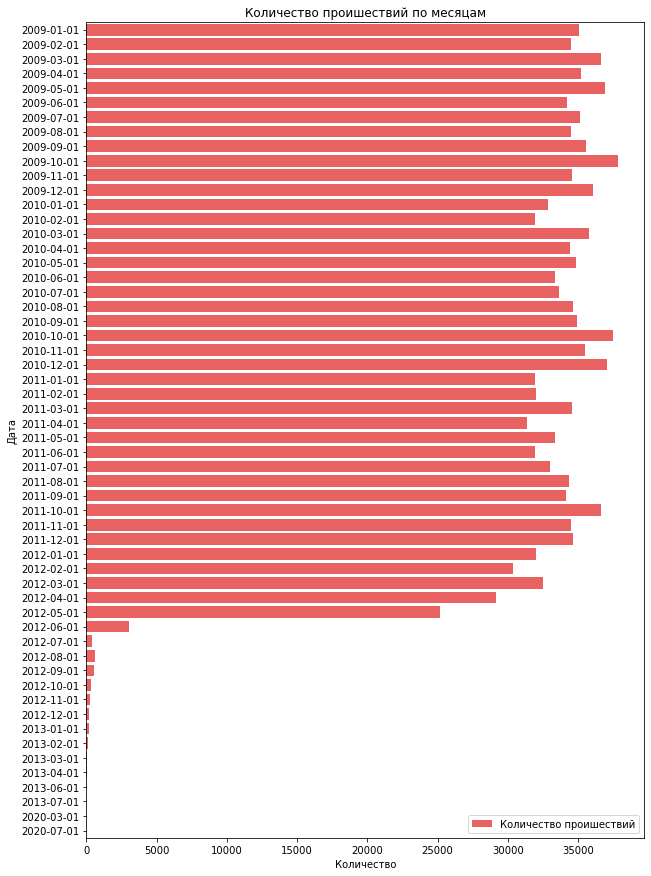

In [11]:
#установка размера
f, ax = plt.subplots(figsize=(10, 15))

#отрисова
sns.barplot(data =collisions_count, 
            x='collision_count',
            y = 'collision_date',
            palette = ['r'],
            alpha=0.7, label = 'Количество проишествий', ax=ax)
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")
#plt.xticks(rotation=90)
plt.title("Количество проишествий по месяцам")
plt.show()

Начиная с января 2012 года данные рассматривать не будем, поскольку происходит резкое падение количество проишествий, которое можно объяснить только недостатком данных. 

У нас достаточно небольшой период наблюдений, всего 3 года, тоесть по три наблюдения на каждый месяц. Обнаруживаются высокие значения в осенние месяцы. Сентябрь-октябрь, однако в целом их вероятно можно объяснить случайными отклонениями. 

### Аналитические задачи

- Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП;
- Существует ли зависимость между возрастом автомобиля и суммой страховки;
- Самые частые причины ДТП (таблица parties);
- Самые частые участники ДТП (таблица parties);
- Автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП;
- Сравнительный ущерб оот ДТП с участием трезвых и пьяных водителей;
- Существует ли зависимость количества ДТП от погодных условий;
- Существует ли зависимость серьезности ДТП от погодных факторов;
- Существует ли зависимость типа ДТП от погодных факторов;
- Существует ли зависимость тип ДТП от погодных факторов

#### Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП

In [12]:
sql_query = '''
select distinct road_surface, collision_damage,
COUNT(collision_damage) over (partition by road_surface order by collision_damage) as col_count
from collisions c 
where case_id in (select distinct case_id
				  from parties p 
				  where party_type = 'car')
order by road_surface, col_count'''
#подключение к баде
col_with_weather = pd.read_sql_query(sql_query, con=engine)
col_with_weather

,road_surface,collision_damage,col_count
0,dry,fatal,9746
1,dry,middle damage,156935
2,dry,scratch,463545
3,dry,severe damage,490510
4,dry,small damage,1232957
5,slippery,fatal,12
6,slippery,middle damage,237
7,slippery,scratch,541
8,slippery,severe damage,601
9,slippery,small damage,1359


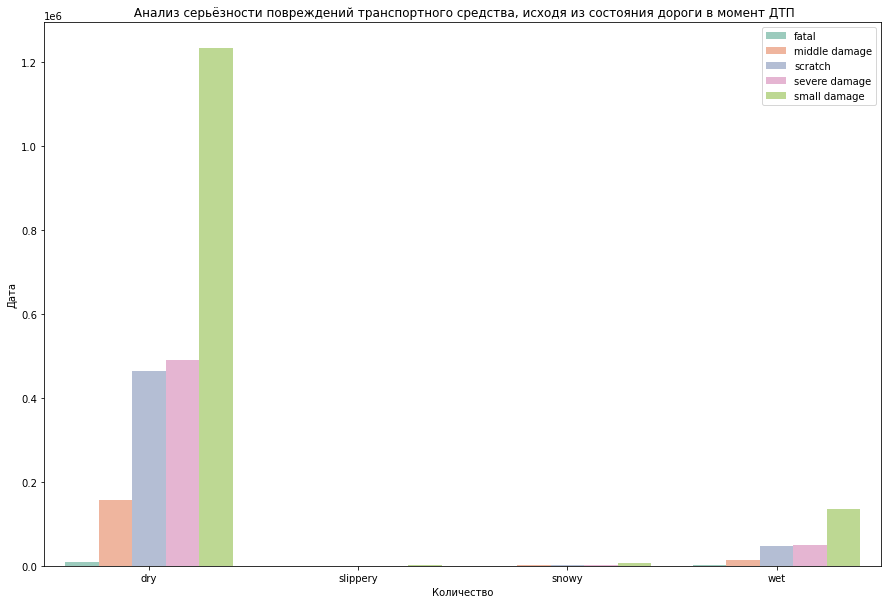

In [13]:
#установка размера
f, ax = plt.subplots(figsize=(15, 10))

#
sns.barplot(data =col_with_weather, 
            x='road_surface',
            y = 'col_count',
            hue  = 'collision_damage',
            palette = "Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")
#plt.xticks(rotation=90)
plt.title(" Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП")
plt.show()

Во всех группах состояния дорожного покрытия мы можем заметить крайне схожые паттерны распределения повреждений. И хотя количество проишествий на покрытиях с разным состояние может отличаться в разы, пропорции самих повреждений очень сильно схожи. Больше всего мерких повреждений, за ними идет серьезное повреждение, потом царапины, среднее повреждение и меньше всего фатальных.

#### Участники ДТП

In [14]:
sql_query = '''
select count(id) as col_count, party_type
from parties p 
group by party_type 
order by count(id)'''
#подключение к базе
col_count = pd.read_sql_query(sql_query, con=engine)
#сразу заполним пропуски
col_count = col_count.fillna('unknown')
col_count

,col_count,party_type
0,3622,unknown
1,8879,other
2,48456,road signs
3,48649,building
4,173488,road bumper
5,2469314,car


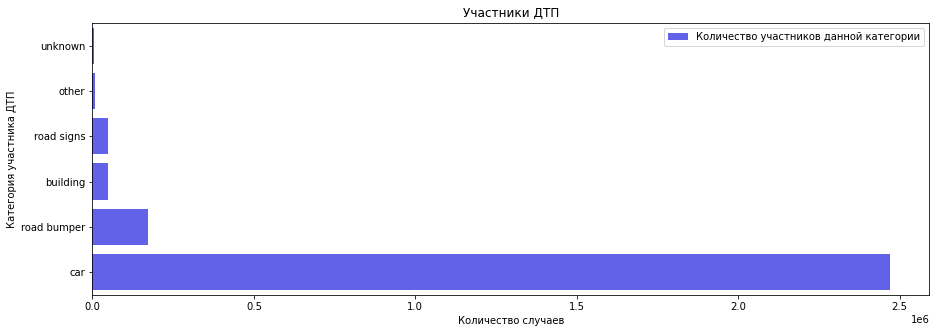

In [15]:
#установка размера
f, ax = plt.subplots(figsize=(15, 5))

#отрисова
sns.barplot(data =col_count, 
            y='party_type',
            x = 'col_count',
            palette = ['b'],
            alpha=0.7, label = 'Количество участников данной категории')
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Количество случаев",
       ylabel="Категория участника ДТП")
#plt.xticks(rotation=90)
plt.title("Участники ДТП")
plt.show()

Как и ожидались самые частые участники ДТП - автомобили. За ними с количеством почти в 15 раз меньше идут отбойники. Здания и дорожные знаки попадают в ДТП почти в равном количестве случаев, примерно в 4 раза реже отбойников.

####  Автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП

In [16]:
sql_query = '''
select *,
col_count/SUM(col_count) over (partition by vehicle_type) as prcnt
from (
select distinct collision_damage, vehicle_type,
count(collision_damage) over(partition by vehicle_type order by collision_damage) as col_count
from
(select case_id , collision_damage 
from collisions) c 
join
(select case_id, vehicle_type
from vehicles) v  on c.case_id = v.case_id) t
'''
#подключение к базе
car_crash = pd.read_sql_query(sql_query, con=engine)
#сразу заполним пропуски
car_crash = car_crash.fillna('unknown')
car_crash

,collision_damage,vehicle_type,col_count,prcnt
0,severe damage,coupe,442780,0.437932
1,middle damage,coupe,140402,0.138865
2,scratch,coupe,418973,0.414385
3,fatal,coupe,8916,0.008818
4,severe damage,hatchback,45595,0.420385
5,middle damage,hatchback,20362,0.187737
6,fatal,hatchback,2786,0.025687
7,scratch,hatchback,39717,0.366190
8,middle damage,minivan,22573,0.212981
9,fatal,minivan,527,0.004972


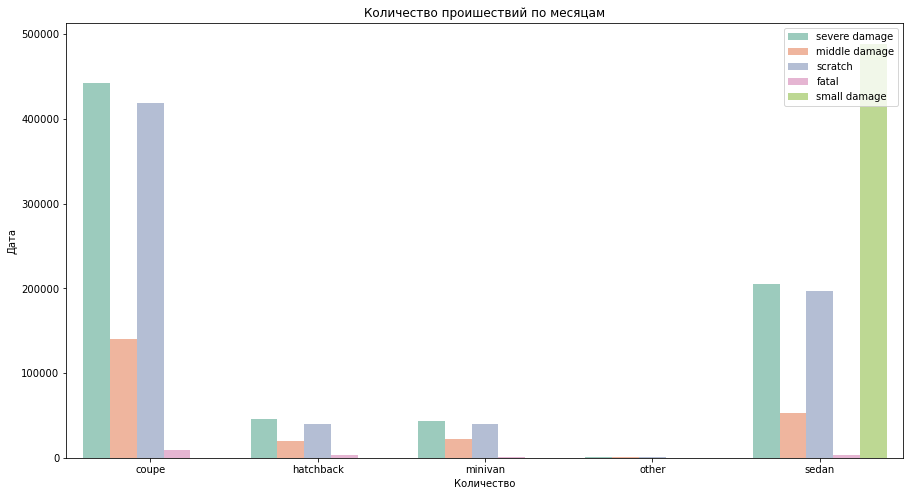

In [17]:
#установка размера
f, ax = plt.subplots(figsize=(15, 8))

#
sns.barplot(data =car_crash, 
            x='vehicle_type',
            y = 'col_count',
            hue  = 'collision_damage',
            palette = "Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")
#plt.xticks(rotation=90)
plt.title("Количество проишествий по месяцам")
plt.show()

В количественном отношении во всех категориях кроме легких повреждений лидируют машины с типом кузова купе. Надо посмотреть еще в процентном соотношении. 

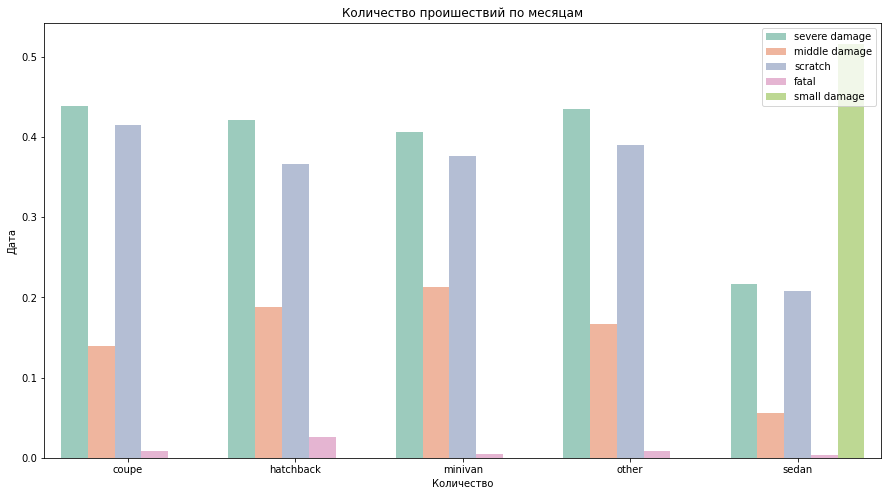

In [18]:
#установка размера
f, ax = plt.subplots(figsize=(15, 8))

#
sns.barplot(data =car_crash, 
            x='vehicle_type',
            y = 'prcnt',
            hue  = 'collision_damage',
            palette = "Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")
#plt.xticks(rotation=90)
plt.title("Количество проишествий по месяцам")
plt.show()

В процентном соотношении лидеры поменялись. Категория Other слишком маленькая, ее можно не рассматривать. В категории Серьезные повреждения и царапины все еще лидируют Купе. В категории средние повреждения лидируют Минивены а в категории не подлежит восстановлению - лидер Хачбек. Мне кажется в наших данных есть аномалия в разрезе малые повреждения. К сожалению в категории кузова Седан у нас имеется аномалии и рассматривать ее в данной статистике не представляется возможным.

### Вывод

- Наименьшее количество ДТП регистрируется в Январе. Рост можно отметить в сентябре. Я думаю что январская просадка связана с наличием праздничных дней и возможно порой отпусков и + зимой автомобилисты часто начинают меньше использовать свой транспорт, а порой в целом не используют личный транспорт до весны. А сентябрьский подъем связан с началом делового сезона после летних отпусков.
- Во всех группах состояния дорожного покрытия мы можем заметить крайне схожые паттерны распределения повреждений. И хотя количество проишествий на покрытиях с разным состояние может отличаться в разы, пропорции самих повреждений очень сильно схожи. Больше всего мелких повреждений, за ними идет серьезное повреждение, потом царапины, среднее повреждение и меньше всего фатальных.
- Как и ожидались самые частые участники ДТП - автомобили. За ними с количеством почти в 15 раз меньше идут отбойники. Здания и дорожные знаки попадают в ДТП почти в равном количестве случаев, примерно в 4 раза реже отбойников.
- В количественном отношении во всех категориях кроме легких повреждений лидируют машины с типом кузова купе. Надо посмотреть еще в процентном соотношении. В процентном соотношении лидеры поменялись. Категория Other слишком маленькая, ее можно не рассматривать. В категории Серьезные повреждения и царапины все еще лидируют Купе. В категории средние повреждения лидируют Минивены а в категории не подлежит восстановлению - лидер Хачбек. Мне кажется в наших данных есть аномалия в разрезе малые повреждения. К сожалению в категории кузова Седан у нас имеется аномалии и рассматривать ее в данной статистике не представляется возможным.

## Модель для оценки водительского риска

Подготовим предварительный набор данных на основе предположения заказчика.

In [19]:
sql_query = '''
select  at_fault,
		vehicle_type,
        vehicle_transmission,
        vehicle_age, 
        party_type,
        insurance_premium,
        party_sobriety,
        party_drug_physical,
        cellphone_in_use,
        county_city_location,
        county_location,
        distance,
        direction,
        intersection,
        weather_1,
        location_type,
        collision_damage,
        party_count,
        primary_collision_factor,
        pcf_violation_category,
        type_of_collision,
        motor_vehicle_involved_with,
        road_surface,
        road_condition_1,
        lighting,
        control_device,
        collision_date,
        collision_time
from ((select *
	from collisions 
	where date_part('year', collision_date) = 2012) as c
	join
	(select * 
	from parties
	where party_type = 'car') as p on c.case_id = p.case_id
	join
	(select *
	from vehicles) as v on p.case_id = v.case_id) as t1
where collision_damage != 'scratch'
'''
#подключение к базе and p.party_number = v.party_number
df = pd.read_sql_query(sql_query, con=engine)
df.head()

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,1,coupe,auto,13.0,car,86.0,had not been drinking,None,0.0,3700,...,vehicle code violation,improper turning,hit object,fixed object,dry,normal,daylight,none,2012-01-05,12:50:00
1,1,sedan,manual,0.0,car,19.0,had not been drinking,None,0.0,3010,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,2012-01-23,11:07:00
2,0,sedan,manual,0.0,car,26.0,had not been drinking,None,0.0,3010,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,2012-01-23,11:07:00
3,0,sedan,auto,1.0,car,30.0,had not been drinking,None,0.0,4803,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,not functioning,2012-01-11,14:28:00
4,0,sedan,auto,10.0,car,30.0,had not been drinking,None,0.0,4803,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,not functioning,2012-01-11,14:28:00


In [20]:
print(df.info())
#проверим на пропуски
print('Пропуски по столбцам:')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     118411 non-null  int64  
 1   vehicle_type                 118411 non-null  object 
 2   vehicle_transmission         116545 non-null  object 
 3   vehicle_age                  115046 non-null  float64
 4   party_type                   118411 non-null  object 
 5   insurance_premium            113289 non-null  float64
 6   party_sobriety               116682 non-null  object 
 7   party_drug_physical          8695 non-null    object 
 8   cellphone_in_use             107507 non-null  float64
 9   county_city_location         118411 non-null  object 
 10  county_location              118411 non-null  object 
 11  distance                     118411 non-null  float64
 12  direction                    89466 non-null   object 
 13 

У нас 26 столбцов. at_fault - целевой.

In [21]:
#посмотрим распределение целевого столбца
df.at_fault.value_counts(normalize = True)

0    0.530314
1    0.469686
Name: at_fault, dtype: float64

Есть не очень сильный дисбаланс классов. Класса 0 больше чем класса 1, но разница не сильная.

### EDA

#### vehicle_type

In [22]:
df.vehicle_type.value_counts()

sedan        76765
coupe        35867
hatchback     3283
minivan       2438
other           58
Name: vehicle_type, dtype: int64

Other - очень маленькое количество. Вероятно надо его исключить.

In [23]:
#удалим строки где [df['vehicle_type'] == 'other'
df = df.drop(df[df['vehicle_type'] == 'other'].index)

In [24]:
df['vehicle_type'] = df['vehicle_type'].astype('category')

#### collision_time

In [25]:
df['collision_time'].head()

0    12:50:00
1    11:07:00
2    11:07:00
3    14:28:00
4    14:28:00
Name: collision_time, dtype: object

Состояние водителя зависит от времени суток, поэтому это важный показатель.

In [26]:
#удалим строки с пропусками в столбце collision_time
df = df.drop(df[df['collision_time'].isna()].index)

In [27]:
#оставим только часы, остальное уберем
df['collision_time'] = df['collision_time'].apply(lambda x: x.hour)
df['collision_time'].value_counts()

15    10814
17     9565
16     9033
14     8967
18     8334
13     7781
12     7167
11     6091
7      5687
8      5578
19     5409
10     4920
20     4525
9      4368
21     3799
22     2927
23     2469
6      2264
2      1863
1      1767
0      1739
5      1334
3      1050
4       774
Name: collision_time, dtype: int64

In [28]:
df['collision_time'] = df['collision_time'].astype('category')

#### collision_date

Cтолбец collision_date Очень важен, сложность вождения имеет зависимость от времени года, но в периоде, который мы рассматриваем у нас есть данные только по 5 месяцам. Алгоритм может переобучиться на этих месяцах и другие предсказывать хуже. В таком разрезе столбец нам не подходит, но из него можно извлечь информацию о дне недели. Это будет полезно. 

Извлечем из столбца информацию о дне недели. Остальное удалим.

In [29]:
#оставим только часы, остальное уберем
df['collision_date'] = df['collision_date'].apply(lambda x: x.weekday())
df['collision_date'].value_counts()

4    20058
5    19004
3    16560
2    16175
6    15962
1    15565
0    14901
Name: collision_date, dtype: int64

In [30]:
df['collision_date'] = df['collision_date'].astype('category')

#### control_device

In [31]:
df['control_device'].value_counts()

none               76564
functioning        40906
not functioning      242
obscured              62
Name: control_device, dtype: int64

Я не понял назначение данного устройства а в условиях задачи его смысл не раскрывается подробно. Будем изходить из того, что это что-то важное. Тогда not functioning и obscured - очень малое количество. По смыслу их можно заменить на none или удалить. Я заменю.

In [32]:
control_device_map = {
    'not functioning': 'none',
    'obscured':'none'
}

df['control_device'] = df['control_device'].apply(lambda x: control_device_map[x] if x in control_device_map else x)
df['control_device'].value_counts()

none           76868
functioning    40906
Name: control_device, dtype: int64

In [33]:
#удалим строки с пропусками в столбце control_device
df = df.drop(df[df['control_device'].isna()].index)

In [34]:
df['control_device'] = df['control_device'].astype('category')

#### lighting

In [35]:
df['lighting'].value_counts()

daylight                                   82607
dark with street lights                    21931
dark with no street lights                  8986
dusk or dawn                                3678
dark with street lights not functioning      286
Name: lighting, dtype: int64

Освещенность очень важный фактор. dark with street lights not functioning очень небольшая категория, посмотрим на качество. ЕЕ можно объединить с dark with no street lights. Так и сделаем. А так же удалим строки с пропусками в данной категории.

In [36]:
#удалим строки с пропусками в столбце lighting
df = df.drop(df[df['lighting'].isna()].index)

lighting_map = {
    'dark with street lights not functioning': 'dark with no street lights',
}

df['lighting'] = df['lighting'].apply(lambda x: lighting_map[x] if x in lighting_map else x)
df['lighting'].value_counts()

daylight                      82607
dark with street lights       21931
dark with no street lights     9272
dusk or dawn                   3678
Name: lighting, dtype: int64

In [37]:
df['lighting'] = df['lighting'].astype('category')

#### road_condition_1

In [38]:
df['road_condition_1'].value_counts()

normal            113058
construction        2282
holes                470
obstruction          458
other                418
loose material       188
reduced width        132
flooded               56
Name: road_condition_1, dtype: int64

Состояние самой улицы важный фактор, но в категориях кроме norval маловато значений, однако все они свидетельствуют о проблемах, поэтому объединим их все в одну а пропуски удалим.

In [39]:
#удалим строки с пропусками в столбце road_condition_1
df = df.drop(df[df['road_condition_1'].isna()].index)

road_condition_map = {
    'construction': 'probem',
    'holes': 'probem',
    'obstruction': 'probem',
    'other': 'probem',
    'loose material': 'probem',
    'reduced width': 'probem',
    'flooded': 'probem'
}

df['road_condition_1'] = df['road_condition_1'].apply(lambda x: road_condition_map[x] if x in road_condition_map else x)
df['road_condition_1'].value_counts()

normal    113058
probem      4004
Name: road_condition_1, dtype: int64

In [40]:
df['road_condition_1'] = df['road_condition_1'].astype('category')

### road_surface

In [41]:
df['road_surface'].value_counts()

dry         105883
wet           9957
snowy          560
slippery        66
Name: road_surface, dtype: int64

Важный фактор. категорию slippery объединим со snowy. Они обе скользкие. Пропуски удалим.

In [42]:
#удалим строки с пропусками в столбце road_condition_1
df = df.drop(df[df['road_surface'].isna()].index)

road_surface_map = {
    'slippery': 'snowy'
}

df['road_surface'] = df['road_surface'].apply(lambda x: road_surface_map[x] if x in road_surface_map else x)
df['road_surface'].value_counts()

dry      105883
wet        9957
snowy       626
Name: road_surface, dtype: int64

In [43]:
df['road_surface'] = df['road_surface'].astype('category')

#### motor_vehicle_involved_with

In [44]:
df['motor_vehicle_involved_with'].value_counts()

other motor vehicle               92968
fixed object                       9232
other object                       5292
non-collision                      2820
bicycle                            2721
parked motor vehicle               2012
motor vehicle on other roadway      912
animal                              234
train                                28
Name: motor_vehicle_involved_with, dtype: int64

motor_vehicle_involved_with - объект, с которым произошло ДТП. зависимость виновности в ДТП от объекта с которым произошло столкновение может существовать. Например fixed object не может двигаться и не может быть виновником ДТП.

train и animal - очень маленькие категории. При плохом качестве модели попробуем их перенести в other object. Пока оставим как есть.

In [45]:
#удалим строки с пропусками в столбце motor_vehicle_involved_with
df = df.drop(df[df['motor_vehicle_involved_with'].isna()].index)

#сменим тип столбца
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].astype('category')

#### type_of_collision

In [46]:
df['type_of_collision'].value_counts()

rear end      44882
broadside     25833
sideswipe     19721
hit object     9959
head-on        6792
other          5952
overturned     2639
Name: type_of_collision, dtype: int64

type_of_collision - тип проишествия. Виновность в дтп может зависить от типа столкновения.

In [47]:
#удалим строки с пропусками в столбце type_of_collision
df = df.drop(df[df['type_of_collision'].isna()].index)

#сменим тип столбца
df['type_of_collision'] = df['type_of_collision'].astype('category')

#### primary_collision_factor

In [48]:
df['primary_collision_factor'].value_counts()

vehicle code violation    111699
unknown                     1759
other than driver           1652
other improper driving       422
fell asleep                    3
Name: primary_collision_factor, dtype: int64

primary_collision_factor - основной фактор аварии. Этот столбец очень похож на столбец pcf_violation_category - категория нарушения. сравним их.

In [49]:
df['pcf_violation_category'].value_counts()

speeding                             41007
automobile right of way              15053
improper turning                     12869
dui                                  10237
unsafe lane change                   10130
traffic signals and signs             7529
wrong side of road                    3196
unsafe starting or backing            2715
following too closely                 2359
unknown                               1882
pedestrian violation                  1665
other than driver (or pedestrian)     1652
other hazardous violation             1145
improper passing                      1011
pedestrian right of way                951
other improper driving                 422
other equipment                        149
impeding traffic                        80
hazardous parking                       43
brakes                                  20
lights                                  16
fell asleep                              3
Name: pcf_violation_category, dtype: int64

Оставим pcf_violation_category - он более информативен. Только категории есть совсем маленькие. перенесем их в other improper driving

In [50]:
#удалим строки с пропусками в столбце pcf_violation_category
df = df.drop(df[df['pcf_violation_category'].isna()].index)

pcf_violation_category_map = {
    'fell asleep': 'other improper driving',
    'lights': 'other improper driving',
    'hazardous parking': 'other improper driving',
    'impeding traffic': 'other improper driving',
    'brakes': 'other improper driving'
}

df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: pcf_violation_category_map[x] if x in pcf_violation_category_map else x)

#удалим лишний столбец
df = df.drop('primary_collision_factor', axis = 1)

#сменим тип столбца
df['pcf_violation_category'] = df['pcf_violation_category'].astype('category')
df['pcf_violation_category'].value_counts()

speeding                             41007
automobile right of way              15053
improper turning                     12869
dui                                  10237
unsafe lane change                   10130
traffic signals and signs             7529
wrong side of road                    3196
unsafe starting or backing            2715
following too closely                 2359
unknown                               1882
pedestrian violation                  1665
other than driver (or pedestrian)     1652
other hazardous violation             1145
improper passing                      1011
pedestrian right of way                951
other improper driving                 584
other equipment                        149
Name: pcf_violation_category, dtype: int64

#### party_count

In [51]:
df['party_count'].value_counts()

2     71590
3     21281
1      9809
4      7522
5      2575
6       787
7       276
9       153
8       111
10       30
Name: party_count, dtype: int64

Для определения виновности имеет значение количество участников. Если участник 1 - то в целом понятно, что он вероятно виновен, поэтому объединим все что больше одного в одну категорию.

In [52]:
df['party_count'] = df['party_count'].apply(lambda x: 1 if x == 1 else 2 )
df['party_count'] = df['party_count'].astype('category')
df['party_count'].value_counts()

2    104325
1      9809
Name: party_count, dtype: int64

#### collision_damage

collision_damage - ущерб при аварии. Ущерб при аварии на мой взгляд не зависит от виновности или не виновности участника ДТП. удалим столбец.

In [53]:
#удалим строки с пропусками в столбце collision_damage
df = df.drop('collision_damage', axis = 1)

#### location_type

In [54]:
df['location_type'].value_counts()

highway         45080
ramp             6097
intersection     2770
Name: location_type, dtype: int64

Поведение водителей разнится в зависимости от нахождения на шоссе и в городе. оставим этот столбец. пропуски заполним значением other

In [55]:
df['location_type'] = df['location_type'].fillna('other')

df['location_type'] = df['location_type'].astype('category')
df['location_type'].value_counts()

other           60187
highway         45080
ramp             6097
intersection     2770
Name: location_type, dtype: int64

#### weather_1

In [56]:
df['weather_1'].value_counts()

clear      92565
cloudy     16556
raining     4059
fog          378
snowing      260
other         61
wind          23
Name: weather_1, dtype: int64

Этот столбец важен, он влияет на водителя. Только категорию wind объединим с other. Пропуски заполним other.

In [57]:
df['weather_1'] = df['weather_1'].fillna('other')

weather_map = {
    'wind': 'other'
}

df['weather_1'] = df['weather_1'].apply(lambda x: weather_map[x] if x in weather_map else x)

#сменим тип столбца
df['weather_1'] = df['weather_1'].astype('category')
df['weather_1'].value_counts()

clear      92565
cloudy     16556
raining     4059
fog          378
other        316
snowing      260
Name: weather_1, dtype: int64

#### intersection

Перекресток является фактором повышающим вероятность аварии. Но никак не влияет на вероятность быт в ней виновным. Удаляем.

In [58]:
df = df.drop('intersection', axis = 1)

#### direction

In [59]:
df['direction'].value_counts()

north    24435
south    23909
west     19543
east     18818
Name: direction, dtype: int64

От направления зависит куда светит солнце. По хорошему можно сделать дополнительный признак. Объединив время и направление. Сделаем это если качество модели без этого будет низким. Пропуски заполним значением unknown

In [60]:
df['direction'] = df['direction'].fillna('unknown')
df['direction'] = df['direction'].astype('category')
df['direction'].value_counts()

unknown    27429
north      24435
south      23909
west       19543
east       18818
Name: direction, dtype: int64

#### distance

Расстояние от главной дороги. Странный столбец. Не очевидно что он характеризует. Удалим его.

In [61]:
#удалим строки с пропусками в столбце distance
df = df.drop('distance', axis = 1)

#### county_location

Виновность водителя никак не зависит от штата проишествия. Удаляем

In [62]:
#удалим строки с пропусками в столбце county_location
df = df.drop('county_location', axis = 1)

#### county_city_location

Виновность водителя мало зависит от географического положения автомобиля. Удаляем.

In [63]:
#удалим строки с пропусками в столбце county_city_location
df = df.drop('county_city_location', axis = 1)

#### cellphone_in_use

In [64]:
df['cellphone_in_use'].value_counts()

0.0    102023
1.0      2229
Name: cellphone_in_use, dtype: int64

Наличие телефона в машине и разговор по нему сожет быть причиной аварии. Оставляем признак. Пропуски заполним 0

In [65]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int')
df['cellphone_in_use'] = df['cellphone_in_use'].astype('category')

#### party_drug_physical

In [66]:
df['party_drug_physical'].value_counts()

G                        5800
under drug influence     1255
sleepy/fatigued           517
not applicable            512
impairment - physical     170
Name: party_drug_physical, dtype: int64

Мне кажется это один их важнейших факторов. заполним пропуски значением G-Impairment Unknown

In [67]:
#заполним строки с пропусками в столбце party_drug_physical
df['party_drug_physical'] = df['party_drug_physical'].fillna('impairment unknown')

party_drug_physical_map = {
    'G': 'impairment unknown'
}

df['party_drug_physical'] = df['party_drug_physical'].apply(lambda x: party_drug_physical_map[x] if x in party_drug_physical_map else x)

#сменим тип столбца
df['party_drug_physical'] = df['party_drug_physical'].astype('category')
df['party_drug_physical'].value_counts()

impairment unknown       111680
under drug influence       1255
sleepy/fatigued             517
not applicable              512
impairment - physical       170
Name: party_drug_physical, dtype: int64

#### party_sobriety

In [68]:
df['party_sobriety'].value_counts()

had not been drinking                     98572
had been drinking, under influence         6293
impairment unknown                         5800
had been drinking, not under influence      921
had been drinking, impairment unknown       524
not applicable                              512
Name: party_sobriety, dtype: int64

Трезвось участника. Этот показатель очень сильно влияет на поведение водителя и может свидетельствовать о виновности или невиновности водителя. Пропуски заполним значением impairment unknown

In [69]:
#заполним строки с пропусками в столбце party_sobriety
df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')
#сменим тип столбца
df['party_sobriety'] = df['party_sobriety'].astype('category')
df['party_sobriety'].value_counts()

had not been drinking                     98572
impairment unknown                         7312
had been drinking, under influence         6293
had been drinking, not under influence      921
had been drinking, impairment unknown       524
not applicable                              512
Name: party_sobriety, dtype: int64

#### insurance_premium

In [70]:
df['insurance_premium'].describe()

count    109306.000000
mean         38.609939
std          16.351185
min           0.000000
25%          25.000000
50%          36.000000
75%          50.000000
max         105.000000
Name: insurance_premium, dtype: float64

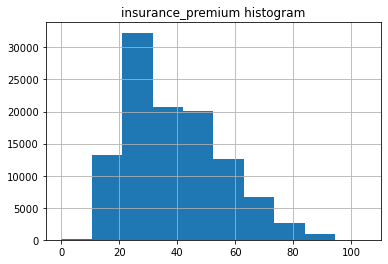

In [71]:
df['insurance_premium'].hist()
plt.title('insurance_premium histogram')
plt.show()

Может влиять на поведение водителя. Полное покрытие страховкой может делать водителя более рисковым и наоборот. пропуски заполним нулями.

In [72]:
#заполним строки с пропусками в столбце insurance_premium
df['insurance_premium'] = df['insurance_premium'].fillna(0.0)

#### party_type

Тип участника. Мы рассматриваем только машины. Поэтому данный столбец можно удалить.

In [73]:
#удалим строки с пропусками в столбце party_type
df = df.drop('party_type', axis = 1)

#### vehicle_age

In [74]:
df['vehicle_age'].describe()

count    110975.000000
mean          4.908538
std           3.269856
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max         161.000000
Name: vehicle_age, dtype: float64

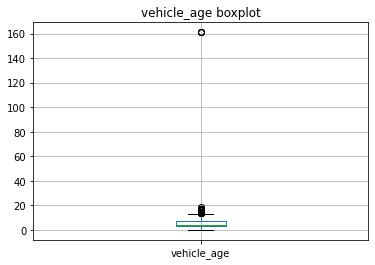

In [75]:
df.boxplot(column = 'vehicle_age')
plt.title('vehicle_age boxplot')
plt.show()

Возраст машины. Честно говоря я не считаю, что возраст машины влияет на виновность в ДТП, но тем не менее по условию заказчика есть требование его использовать. Пропуски заполним медианным значением по столбцу. Все значения старше 12 заменим на 12.

In [76]:
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 12 if x>12 else x)

#заполним строки с пропусками в столбце vehicle_age
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())

In [77]:
df['vehicle_age'].describe()

count    114134.000000
mean          4.854881
std           3.031928
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max          12.000000
Name: vehicle_age, dtype: float64

In [78]:
df['vehicle_age'] = df['vehicle_age'].astype('int')
df['vehicle_age'] = df['vehicle_age'].astype('category')

#### vehicle_transmission

In [79]:
#удалим строки с пропусками в столбце county_city_location
df = df.drop('vehicle_transmission', axis = 1)

Различные типы коробки передач никак не корелируют с виновностью в ДТП.

In [80]:
print(df.info())
#проверим на пропуски
print('Пропуски по столбцам:')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114134 entries, 0 to 118410
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   at_fault                     114134 non-null  int64   
 1   vehicle_type                 114134 non-null  category
 2   vehicle_age                  114134 non-null  category
 3   insurance_premium            114134 non-null  float64 
 4   party_sobriety               114134 non-null  category
 5   party_drug_physical          114134 non-null  category
 6   cellphone_in_use             114134 non-null  category
 7   direction                    114134 non-null  category
 8   weather_1                    114134 non-null  category
 9   location_type                114134 non-null  category
 10  party_count                  114134 non-null  category
 11  pcf_violation_category       114134 non-null  category
 12  type_of_collision            114134 non-null

Для модели будем использовать следующий набор признаков.
- **vehicle_type** - тип кузова, Аварийности зависит от паттернов поведения водителя, люди предпочитающие скорость - выбирают купе, а семейные, предпочитающие вместительность,  чаще выбирают minivan. 
- **collision_time** - время проишествия. От вермени суток аварийность зависит.
- **collision_date** - дата проишествия. Важная информация, но она у нас не по всему году. Оставим преобразовав ко дню недели.
- **control_device** - устройство управления. Не понятный мне столбец. Оставим на всякий случай. Если будут плохие метрики, можно попробовать удалить.
- **lighting** - освещенность, важный фактор, влияет на видимость на дороге.
- **road_condition_1** - состояние улицы важнейший фактор влияющий на вероятность ДТП.
- **road_surface** - состояние покрытия - важнейший фактор.
- **motor_vehicle_involved_with** - объект, с которым произошло ДТП. зависимость виновности в ДТП от объекта с которым произошло столкновение может существовать. Например fixed object не может двигаться и не может быть виновником ДТП.
- **type_of_collision** - тип проишествия. Виновность в дтп может зависить от типа столкновения.
- **pcf_violation_category** - категория нарушения. Информативный столбец. Некоторые нарушения очевидным образом указывают на виновного.
- **party_count** - количество участников. Если участник один, то крайне вероятно, что он виновен
- **location_type** - тип дороги. Поведение водителей разнится в зависимости от нахождения на шоссе и в городе.
- **weather_1** - погода. Погада важный фактор при вождении.
- **intersection** - перекресток является фактором повышающим вероятность аварии.
- **direction** - направление движения. Совместно со временем движения может свидетельствовать а том куда светит солнце.
- **cellphone_in_use** - Наличие телефона в машине, может стать причиной аварии.
- **party_drug_physical** - Состояние участника. Состояние водителя сильно влияет на его вождение.
- **party_sobriety** - трезвость участника. Так же сильно влияет на поведение и рекцию вадотеля.
- **insurance_premium** - страховая премия. Может влиять на поведение водителя. Полное покрытие страховкой может делать водителя более рисковым и наоборот.
- **vehicle_age** - возраст машины нужно использовать по требованию заказчика

In [81]:
target = ['at_fault']
numeric = ['insurance_premium']
category = list(set(df.columns) - set(numeric) - set(target))
category, numeric

(['vehicle_age',
  'weather_1',
  'control_device',
  'direction',
  'party_drug_physical',
  'type_of_collision',
  'road_condition_1',
  'location_type',
  'collision_time',
  'party_count',
  'party_sobriety',
  'pcf_violation_category',
  'motor_vehicle_involved_with',
  'collision_date',
  'vehicle_type',
  'road_surface',
  'cellphone_in_use',
  'lighting'],
 ['insurance_premium'])

Нормализуем числовые данные, обработаем категориальные.

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

In [83]:
#Разделим данные на признаки а целефой столббец
X = df.drop(target, axis = 1)
y = df[target]

#разделим данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)
print('X - size:', X.shape)
print('X - Train size:', X_train.shape)
print('X - Test size:', X_test.shape)
print('X - Validation size:', X_val.shape)
print('y - size:', y.shape)
print('y - Train size:', y_train.shape)
print('y - Test size:', y_test.shape)
print('y - Validation size:', y_val.shape)

X - size: (114134, 19)
X - Train size: (79893, 19)
X - Test size: (17120, 19)
X - Validation size: (17121, 19)
y - size: (114134, 1)
y - Train size: (79893, 1)
y - Test size: (17120, 1)
y - Validation size: (17121, 1)


In [84]:
#отключим предупреждения
pd.options.mode.chained_assignment = None

#инициализация StandardScaler
scaler = StandardScaler()
#скалер обучаем только на трейне
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])

Некоторые алгоритмы могут работать с категориальными данными. Для них оставим как есть, для остальных обработаем категории.

In [85]:
X_train_c = X_train.copy()
X_test_c = X_test.copy()
X_val_c = X_val.copy()

In [86]:
#инициализация OneHotEncoder
enc = OneHotEncoder(handle_unknown='error', sparse = 'False', drop='first')
#OneHotEncoder обучаем только на трейне
enc.fit(X_train[category])
#получим закодированные категории
X_train_cat =pd.DataFrame(enc.transform(X_train[category]).toarray(), index = X_train.index)
X_test_cat =pd.DataFrame(enc.transform(X_test[category]).toarray(), index = X_test.index)
X_val_cat =pd.DataFrame(enc.transform(X_val[category]).toarray(), index = X_val.index)

#объединим столбцы с числовыми признаками и столбцы с закодированными категориями
X_train =  X_train.drop(category, axis = 1).join(X_train_cat)
X_test = X_test.drop(category, axis = 1).join(X_test_cat)
X_val = X_val.drop(category, axis = 1).join(X_val_cat)

#Проверим размерности признаков
print('X - Train size:', X_train.shape)
print('X - Test size:', X_test.shape)
print('X - Val size:', X_val.shape)

X - Train size: (79893, 105)
X - Test size: (17120, 105)
X - Val size: (17121, 105)


In [87]:
#преобразуем все признаки в тензоры с типом FloatTensor
X_train_ = torch.FloatTensor(X_train.reset_index(drop=True).values)
X_test_ = torch.FloatTensor(X_test.reset_index(drop=True).values)
X_val_ = torch.FloatTensor(X_val.reset_index(drop=True).values)
y_train_ = torch.FloatTensor(y_train.values)
y_test_ = torch.FloatTensor(y_test.values)
y_val_ = torch.FloatTensor(y_val.values)

### Вывод

Признаки отобраны. Числовые данные нормализированы, категориальные обработаны. Пропуски заполнены и удалены по необходимости. Тензоры преобразованны.

## Выбор модели

### LogisticRegression

Начнем с LogisticRegression.

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
import optuna

In [90]:
lr_model = LogisticRegression(C = 0.5, random_state=42, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 1000)
lr_model.fit(X_train, y_train.values.ravel())
lr_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test.values.ravel(), lr_model.predict_proba(X_test)[:,1])

0.7523121731905726

In [91]:
roc_auc_score(y_val.values.ravel(), lr_model.predict_proba(X_val)[:,1])

0.7541913174719705

Для старта качество более менее. Попробуем улучшить качество с помощью Optuna.

In [92]:
def objective_lr(trial):

    param = {     
        'C' : trial.suggest_float("C", 0.1, 100, log=True),
        'penalty' : trial.suggest_categorical('penalty', ["l1", "l2"]),
        'max_iter' : trial.suggest_int('max_iter', 100, 1000, log=True),
    }

    model = LogisticRegression(random_state=42, class_weight = 'balanced', solver = 'liblinear', **param)
    model.fit(X_train, y_train.values.ravel())

    accuracy = roc_auc_score(y_test.values.ravel(), model.predict_proba(X_test)[:, 1])

    return accuracy

In [93]:
%%time
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100, timeout=600, n_jobs=-1)

[I 2022-10-06 00:22:55,206] A new study created in memory with name: no-name-d6e9c1cb-9887-472d-8552-3d5ac719165f
C:\Users\72090\AppData\Roaming\Python\Python39\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-10-06 00:23:07,809] Trial 3 finished with value: 0.7521706551609701 and parameters: {'C': 99.24154544773505, 'penalty': 'l2', 'max_iter': 744}. Best is trial 3 with value: 0.7521706551609701.
[I 2022-10-06 00:23:10,813] Trial 4 finished with value: 0.7511095643402719 and parameters: {'C': 0.11458720078824249, 'penalty': 'l2', 'max_iter': 637}. Best is trial 3 with value: 0.7521706551609701.
[I 2022-10-06 00:28:59,904] Trial 2 finished with value: 0.7523700264731144 and parameters: {'C': 0.2950940279038015, 'penalty': 'l1', 'max_iter': 886}. Best is trial 2 with value: 0.7523700264731144.
[I 2022-10-06 00

Wall time: 16min 43s


Качество при подборе параметров почти не увеличилось. Проведем проверку подобранных параметров.

In [94]:
best_params_lr = study_lr.best_trial.params
best_params_lr

{'C': 0.2950940279038015, 'penalty': 'l1', 'max_iter': 886}

In [95]:
model = LogisticRegression(random_state=42,
                           class_weight = 'balanced',
                           solver = 'liblinear',
                           **best_params_lr)
model.fit(X_train, y_train.values.ravel())

roc_auc_score(y_val.values.ravel(), model.predict_proba(X_val)[:, 1])

0.7542548092022463

При подборе гиперпараметров качество толком не увеличилось. Перейдем к следующей модели.

### NN

От идеи обучать нейросеть пришлось отказаться. Среднее время эпохи выходило порядка 15 минут. Обучение даже в 50 эпох растягивается к сожалению на неприемлимое время. А одна две дают качество на уровне Логистической регрессии.

### LightGBM

Попробуем LightGBM.

In [96]:
import lightgbm as lgb

In [97]:
def objective_lgbm(trial):

    param = {     
        'max_depth' : trial.suggest_int("max_depth", 3, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True),
        'num_leaves' : trial.suggest_int("num_leaves", 3, 20)
        ###
    }

    model = lgb.LGBMClassifier(n_jobs=-1, random_state = 42,  **param)
    model.fit(X_train_c, y_train.values.ravel())

    accuracy = roc_auc_score(y_test.values.ravel(), model.predict_proba(X_test_c)[:, 1])

    return accuracy

In [98]:
%%time
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=500, timeout=600, n_jobs=-1)

[I 2022-10-06 00:41:12,221] A new study created in memory with name: no-name-e046f4f0-98b4-4ed7-ab62-4a94da698dd5
C:\Users\72090\AppData\Roaming\Python\Python39\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-10-06 00:41:21,158] Trial 2 finished with value: 0.7826549258872748 and parameters: {'max_depth': 3, 'n_estimators': 675, 'learning_rate': 0.08481584997429716, 'num_leaves': 10}. Best is trial 2 with value: 0.7826549258872748.
[I 2022-10-06 00:41:27,752] Trial 1 finished with value: 0.7810487681399824 and parameters: {'max_depth': 7, 'n_estimators': 2134, 'learning_rate': 0.08408335028108907, 'num_leaves': 3}. Best is trial 2 with value: 0.7826549258872748.
[I 2022-10-06 00:41:29,068] Trial 0 finished with value: 0.7837877616248675 and parameters: {'max_depth': 7, 'n_estimators': 561, 'learning_rate': 0.

Wall time: 10min 39s


In [99]:
best_params_lgbm = study_lgbm.best_trial.params
best_params_lgbm

{'max_depth': 10,
 'n_estimators': 2307,
 'learning_rate': 0.022953460147270968,
 'num_leaves': 19}

In [100]:
model_lgb = lgb.LGBMClassifier(n_jobs=-1, random_state = 42,  **best_params_lgbm)
model_lgb.fit(X_train_c, y_train.values.ravel())

roc_auc_score(y_val.values.ravel(), model_lgb.predict_proba(X_val_c)[:, 1])

0.7864463634030678

В срачнении и первой моделью качество улучшилось. Попробуем третью модель. 

### CatBoostClassifier

In [101]:
from catboost import CatBoostClassifier

In [102]:
def objective(trial):

    param = {     
        'depth' : trial.suggest_int("depth", 3, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True)
        ###
    }

    model = CatBoostClassifier(cat_features=category, early_stopping_rounds = 100, loss_function= 'Logloss', random_state = 42,  **param)
    model.fit(X_train_c, y_train, eval_set=[(X_test_c, y_test)], verbose=0)

    accuracy = roc_auc_score(y_test, model.predict_proba(X_test_c)[:, 1])

    return accuracy

In [103]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500, timeout=600, n_jobs=-1)

[I 2022-10-06 00:52:12,339] A new study created in memory with name: no-name-88bb6463-06ce-4b68-912a-e462b092f7b8
C:\Users\72090\AppData\Roaming\Python\Python39\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-10-06 01:00:14,476] Trial 0 finished with value: 0.8471146904286599 and parameters: {'depth': 8, 'n_estimators': 1991, 'learning_rate': 0.37594761525648324}. Best is trial 0 with value: 0.8471146904286599.
[I 2022-10-06 01:15:51,498] Trial 3 finished with value: 0.8389298202574508 and parameters: {'depth': 8, 'n_estima

Wall time: 24min 30s


In [104]:
best_params = study.best_trial.params
best_params

{'depth': 10, 'n_estimators': 625, 'learning_rate': 0.06670363045070472}

In [105]:
model = CatBoostClassifier(cat_features=category, 
                           early_stopping_rounds = 100, 
                           loss_function= 'Logloss', 
                           random_state = 42,
                           ** best_params                           
                          )
model.fit(X_train_c, y_train, eval_set=[(X_test_c, y_test)], verbose=3)
roc_auc_score(y_test, model.predict_proba(X_test_c)[:, 1])


0:	learn: 0.6662385	test: 0.6663349	best: 0.6663349 (0)	total: 932ms	remaining: 9m 41s
3:	learn: 0.6095509	test: 0.6101318	best: 0.6101318 (3)	total: 3.3s	remaining: 8m 31s
6:	learn: 0.5787793	test: 0.5799278	best: 0.5799278 (6)	total: 5.49s	remaining: 8m 4s
9:	learn: 0.5628110	test: 0.5647109	best: 0.5647109 (9)	total: 8.1s	remaining: 8m 18s
12:	learn: 0.5520691	test: 0.5545584	best: 0.5545584 (12)	total: 10s	remaining: 7m 52s
15:	learn: 0.5438233	test: 0.5466329	best: 0.5466329 (15)	total: 12.3s	remaining: 7m 47s
18:	learn: 0.5378764	test: 0.5410395	best: 0.5410395 (18)	total: 14.7s	remaining: 7m 48s
21:	learn: 0.5330397	test: 0.5369287	best: 0.5369287 (21)	total: 17.4s	remaining: 7m 57s
24:	learn: 0.5293827	test: 0.5338101	best: 0.5338101 (24)	total: 20s	remaining: 8m 1s
27:	learn: 0.5264221	test: 0.5312284	best: 0.5312284 (27)	total: 22.4s	remaining: 7m 57s
30:	learn: 0.5243445	test: 0.5294771	best: 0.5294771 (30)	total: 25s	remaining: 7m 58s
33:	learn: 0.5226549	test: 0.5284044	be

0.8553081187777596

In [106]:
roc_auc_score(y_val, model.predict_proba(X_val_c)[:, 1])

0.8576320965077588

Самое лучшее качество получилось на модели CatBoost. ЕЕ результаты будем использовать для оценки важности параметров. Проведем небольшой анализ качества модели. Построим ROC_AUC кривую, рассмотрим матрицу ошибок, полноту и точность.

0.8576320965077588
Threshold value is: 0.4260762905629303


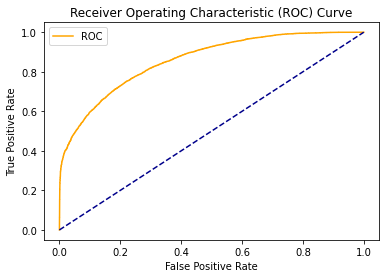

In [107]:
import numpy as np
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val_c)[:, 1])
print(roc_auc_score(y_val, model.predict_proba(X_val_c)[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [108]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model.predict_proba(X_test_c)[:, 1]>=optimal_threshold)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[7038 2016]
 [2038 6028]]

True Positives(TP) =  7038

True Negatives(TN) =  6028

False Positives(FP) =  2016

False Negatives(FN) =  2038


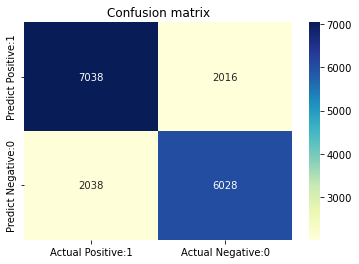

In [109]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion matrix')
plt.show()

Модель достаточно хорошо предсказывает Positive так и Negative. Ошибки есть, они смещены в сторону излишненго прогноза Positive

Recall 0.7515295292795605
Precision 0.7504051863857374


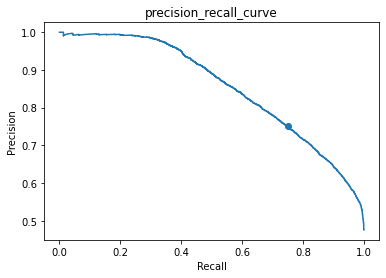

In [110]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.metrics import recall_score, precision_score

print('Recall', recall_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold))
print('Precision', precision_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold))

precision, recall, _ = precision_recall_curve(y_val, model.predict_proba(X_val_c)[:, 1])

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(recall_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold), 
            precision_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold))
plt.title("precision_recall_curve")
plt.show()

Показатели точности и полноты достаточно хорошие.

### Вывод

Оптимальной моделью стал CatBoostClassifier. Метрика ROC AUC у него ,больше 0.85 что является максимальной из рассмотренных моделей. Модель хорошо предсказывает и Positive и Negative классы. Так же модель больше ошибается при прогнозировании позитивного класса, чем негативного.

## Проведите анализ важности факторов ДТП

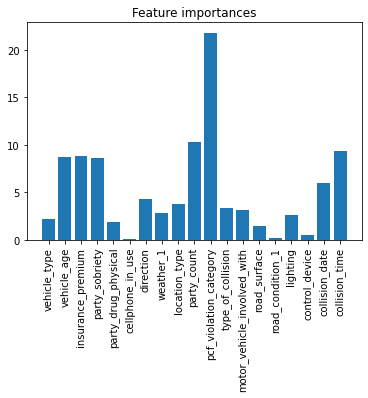

In [111]:
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation = 90) 
plt.title('Feature importances')
plt.show()

In [112]:
sorted(list(zip(model.feature_importances_, X.columns)))

[(0.08639915864245033, 'cellphone_in_use'),
 (0.19473295194788115, 'road_condition_1'),
 (0.526478984468579, 'control_device'),
 (1.4304308416675424, 'road_surface'),
 (1.9131278678332369, 'party_drug_physical'),
 (2.225731245472321, 'vehicle_type'),
 (2.5788456602988856, 'lighting'),
 (2.8398256088253535, 'weather_1'),
 (3.1566022438825523, 'motor_vehicle_involved_with'),
 (3.3472358207682937, 'type_of_collision'),
 (3.7620188752582626, 'location_type'),
 (4.3155700876574965, 'direction'),
 (5.987832350333274, 'collision_date'),
 (8.626176390791038, 'party_sobriety'),
 (8.67952958492479, 'vehicle_age'),
 (8.80901073773382, 'insurance_premium'),
 (9.389897804470788, 'collision_time'),
 (10.33752302836842, 'party_count'),
 (21.793030756654908, 'pcf_violation_category')]

Можно увидель, что модель определила как самые важные 'pcf_violation_category', 'insurance_premium', 'collision_time', 'party_count', 'vehicle_age'. Рассмотрим подробнее 'pcf_violation_category'

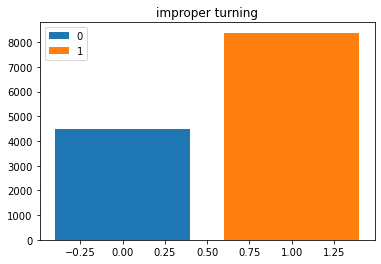

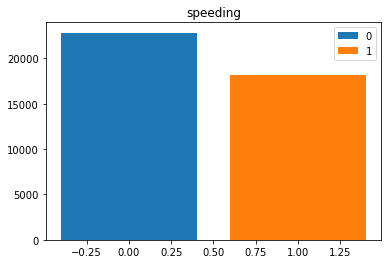

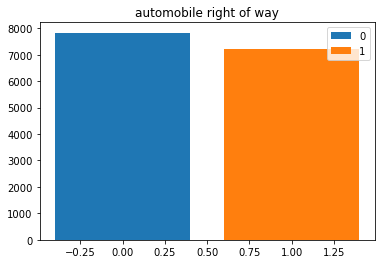

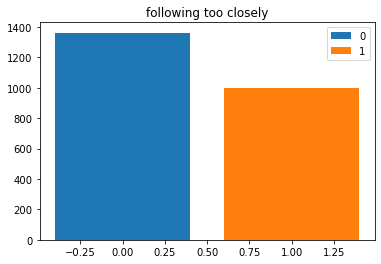

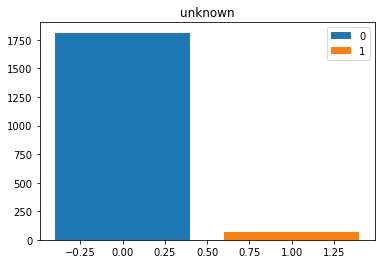

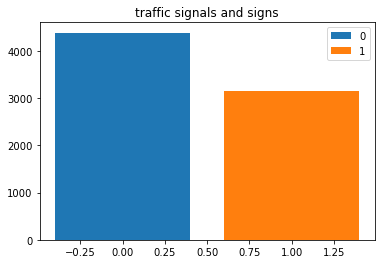

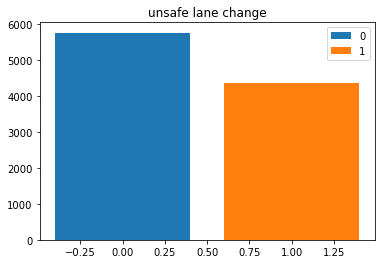

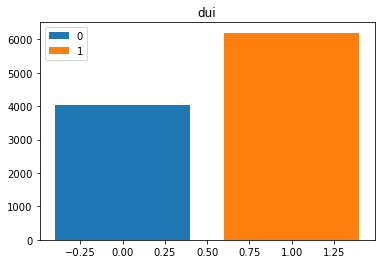

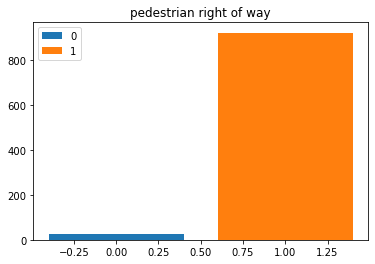

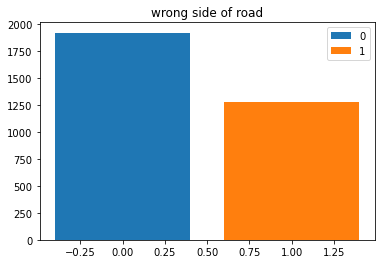

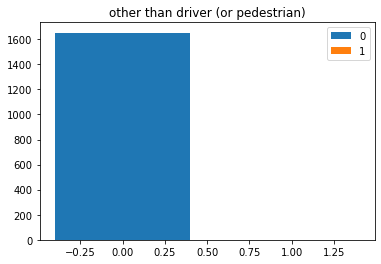

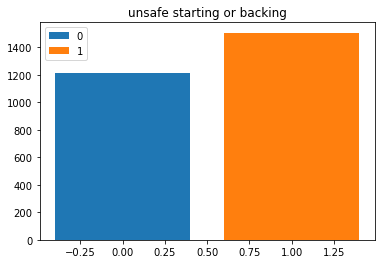

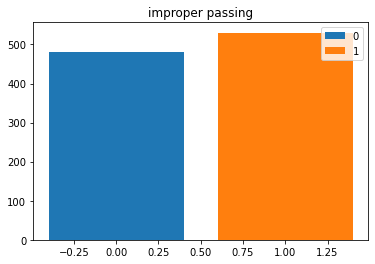

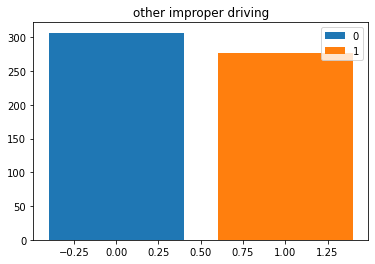

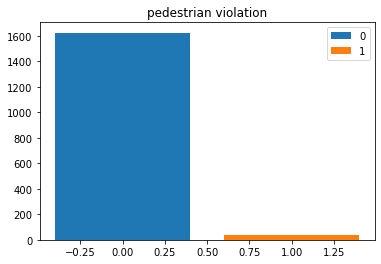

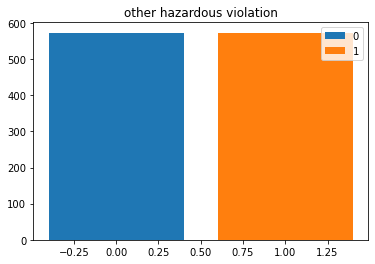

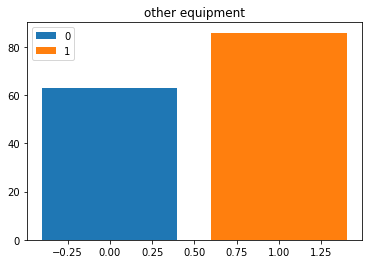

In [113]:
for item in df['pcf_violation_category'].unique():
    zeros = df.query("pcf_violation_category==@item")['at_fault'].value_counts()[0]
    if len(df.query("pcf_violation_category==@item")['at_fault'].value_counts())<2:
        ones = 0
    else:
        ones = df.query("pcf_violation_category==@item")['at_fault'].value_counts()[1]
    plt.bar(0, zeros, label ='0')
    plt.bar(1, ones, label ='1')
    plt.title(item)
    plt.legend()
    plt.show()

Даже визуально можно заметить что при некоторых значениях данного столбца можно с точностью близкой к 100 процентам определить значение таргета. Например при значении "other than driver (or pedestrian)" - сто процентов водителей не виновны в ДТП.

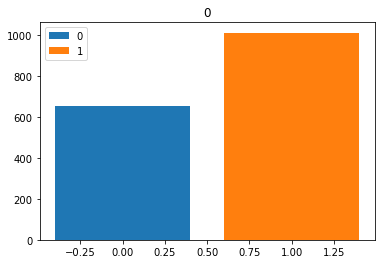

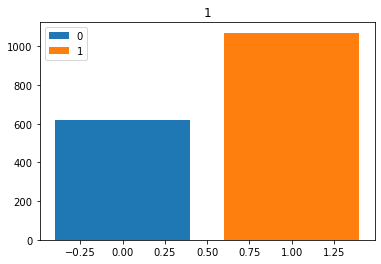

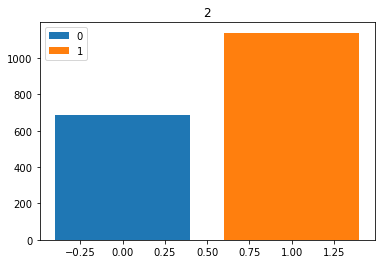

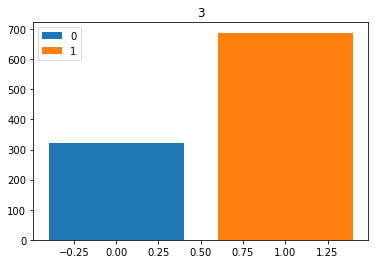

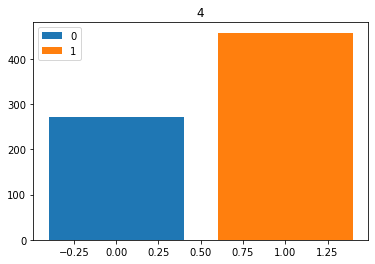

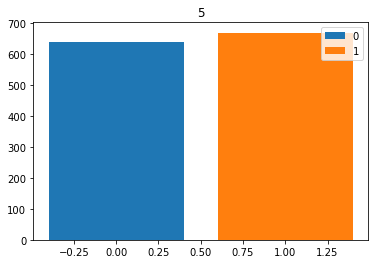

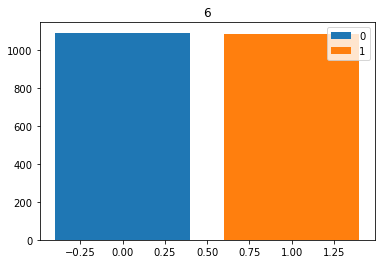

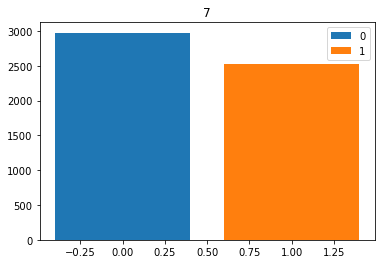

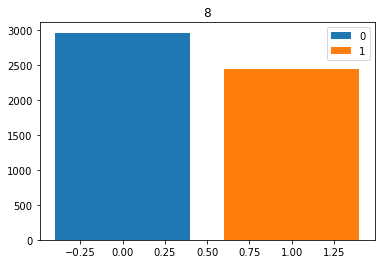

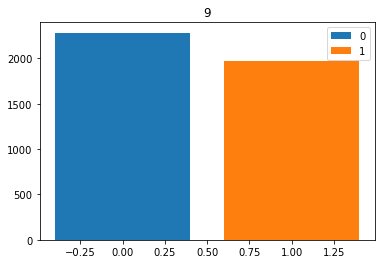

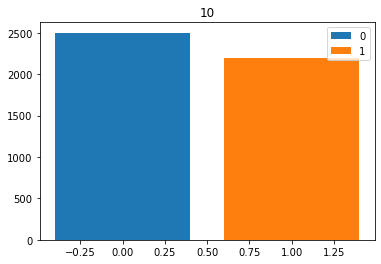

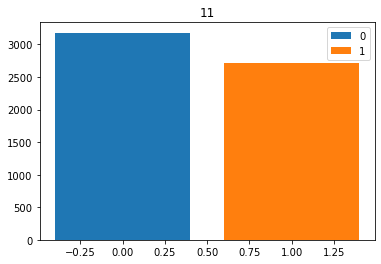

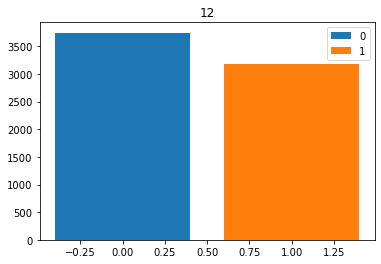

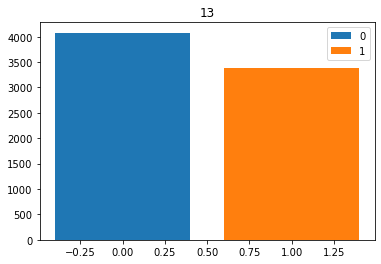

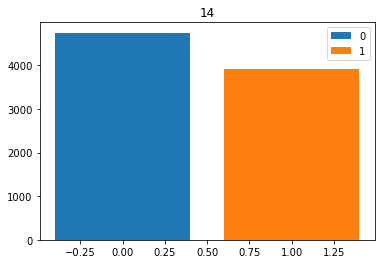

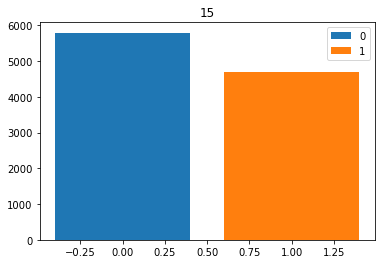

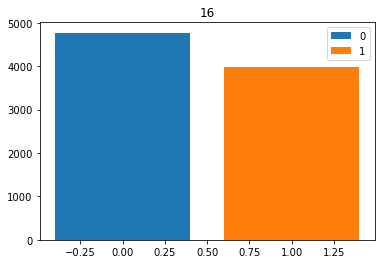

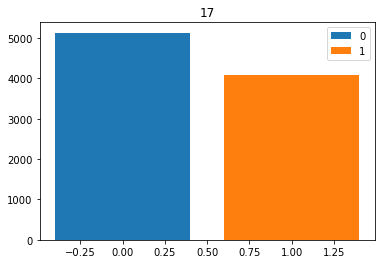

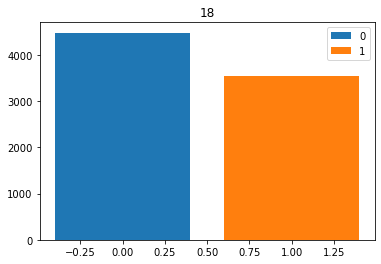

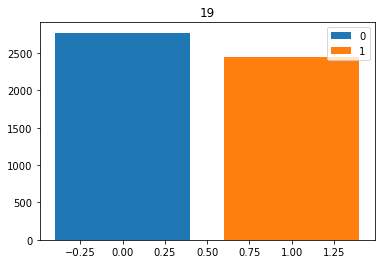

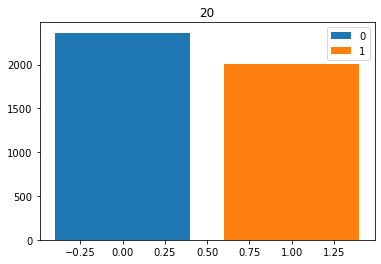

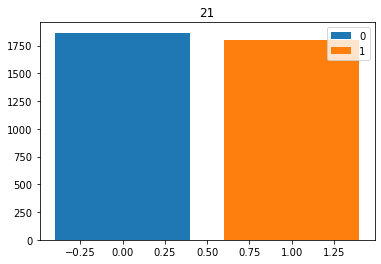

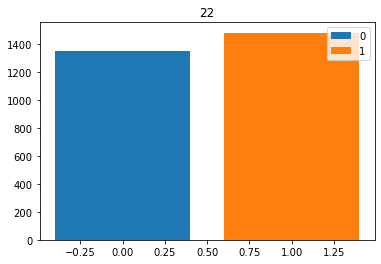

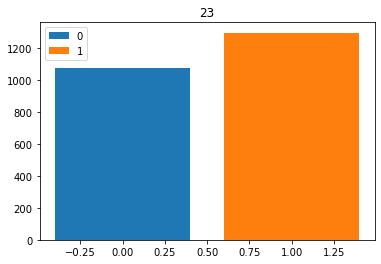

In [114]:
for item in sorted(df['collision_time'].unique()):
    zeros = df.query("collision_time==@item")['at_fault'].value_counts()[0]
    if len(df.query("collision_time==@item")['at_fault'].value_counts())<2:
        ones = 0
    else:
        ones = df.query("collision_time==@item")['at_fault'].value_counts()[1]
    plt.bar(0, zeros, label ='0')
    plt.bar(1, ones, label ='1')
    plt.title(item)
    plt.legend()
    plt.show()

По столбцу "collision_time" тоже в целом достаточно однозначно можно сделать вывод что ночная езда более опасна ДТП, чем дневная. Ночью вероятность ошибки у водителя больше.

## Выводы

На основании предоставленных данных невозможно построение системы оценки риска попасть в ДТП. Данные отображают только одну категорию - "Водители попавшие в ДТП", второй категории - "Водители не попавшие в ДТП" нет совсем. Наша сисетма обучаясь на данных в которых 100% дисбаланс классов учится предказывать, что все поездки закончатся ДТП.

Если же рассматривать таргет, который предложил заказчик - то мы по нему можем предсказать только виновен ли водитель в ДТП или нет. Столбец at_fault именно это и сигнализирует. Однако самый важный признак по которому строиться хорошее предсказание это сведенья о нарушении, которые мы получаем из компетентных органов вероятно вместе с заключением о виновности или невиновности конкретного лица. В результате система предсказания виновности в ДТП в целом теряет смысл, т.к. нам не нужно предсказывать винвного, в акте и так это уже будет написано.

Для сождания модели, которая бы могла предсказывать ДТП, нам дополнительно нужны данные о поездках без ДТП, иначе построить адекватную систему предсказаний не возможно.